# Parameters

In [1]:
from globenn.model import *
import geopy
from geopy import distance
from obspy.taup import plot_travel_times
from obspy.taup import TauPyModel
from glob import glob

# Load style
plt.style.use("../hatsyim.mplstyle")

# for reproducibility
os.environ['PYTHONHASHSEED']= '123'
np.random.seed(123)

# Hyperparameter
rec_typ = 'ISC_array'

# saving parameters
num_pts = 1e4
num_epo = int(2001)
num_blo = 21 #20
coo_sys = 'cartesian'
vel_sha = 'sphere'
vel_typ = 'gladm25'
num_neu = 512
lea_rat = 5e-6
act_fun = torch.nn.ELU
bat_siz = 512 #num_pts // 100
ada_wei = False
opt_fun = torch.optim.Adam
dev_typ = 'cpu'
bac_vel = 10 #6 #10.5

offline, old = False, False

# Model parameters
params = {}
params['model_path'] = '../models/'
params['device'] = dev_typ
params['mixed_precision'] = False
params['num_blocks'] = num_blo
params['act_function'] = act_fun
params['num_points'] = 1e4
params['batch_size'] = bat_siz
params['val_percentage'] = 10
params['num_epochs'] = num_epo
params['sampling_bounds'] = [0.1,0.9]
params['log_frequency'] = 1
params['save_frequency'] = 10
params['learning_rate'] = lea_rat
params['use_scheduler'] = True

PROJECT_NAME='section-3'

# Saving path
model_path = "./../saves/" + PROJECT_NAME
figures_path = model_path + '/'
checkpoints_path = figures_path + 'checkpoints' + '/'
predictions_path = figures_path + 'predictions' + '/'

from pathlib import Path

Path(figures_path).mkdir(parents=True, exist_ok=True)
Path(checkpoints_path).mkdir(parents=True, exist_ok=True)
Path(predictions_path).mkdir(parents=True, exist_ok=True)

# USArray and ISC stations

In [2]:
# Load all stations
ISCall = pd.read_csv('../data/stations.csv')
ISCall = ISCall.rename(columns={"Name":"Channel", "X":"LON", 'Y':'LAT'})

# laod only active stations (from ISC website) to 2021
ISCarray = ISCall[ISCall['description'].str.contains('to 2021')]
ISCarrLon = ISCarray['LON'][::5]
ISCarrLat = ISCarray['LAT'][::5]

# load US array data
USarray = pd.read_excel('../data/_US-TA-StationList.xls')
USarrLon = USarray['LON'][::1]
USarrLat = USarray['LAT'][::1]

# concatenate the two receiver group
AllLon = np.hstack((USarrLon, ISCarrLon))
AllLat = np.hstack((USarrLat, ISCarrLat))

# Traveltime Prediction

In [3]:
eq_properties = {
    'name'       : ['Chile_2010', 'Japan_2011', 'Indonesia_2004', 'Cuba_2020', 'Chile_2015'],
    'lat'        : [-36.122, 38.297, 3.295, 19.44,-31.5705],
    'lon'        : [-72.898, 142.373, 95.982, -78.7545,-71.6703],
    'depth'      : [22.9, 29, 30, 10, 20.7],
    'time'       : [pd.DataFrame({'Time':['06:34:11']}), pd.DataFrame({'Time':['05:46:24']}),pd.DataFrame({'Time':['00:58:53']}),pd.DataFrame({'Time':['19:10:25']}),pd.DataFrame({'Time':['22:54:32']})],
    'stations'   : [539, 553, 516, 142, 112]
}

idx = 0

# Dummy input
r = np.ones((eq_properties['stations'][idx],1)) #I 516 #J 553 #C 539
s = np.ones((eq_properties['stations'][idx],1)) #I 516 #J 553 #C 539

Xb = np.hstack((s, s, s, r, r, r))
yb = r

nFeatures = 6

eq_name = eq_properties['name'][idx]#'sumatra_2004'

if idx==1:
    eq_data = pd.read_excel('../data/'+eq_name.lower()+'.ods')
else:
    eq_data = pd.read_excel('../data/'+eq_name.lower()+'.xlsx')
    
LAT_EQ = eq_properties['lat'][idx]
LON_EQ = eq_properties['lon'][idx]
DEP_EQ = eq_properties['depth'][idx]
TIME_EQ = eq_properties['time'][idx]

# Station name
STAT_NAME = 'ERM'

# Compute distance between two LAT/LON points in degrees
coords_1 = (LAT_EQ, LON_EQ)
coords_2 = (ISCarray[ISCarray['Channel']==STAT_NAME]['LAT'].values, ISCarray[ISCarray['Channel']==STAT_NAME]['LON'].values)
dist_deg = geopy.distance.distance(coords_1, coords_2).km/111
print(dist_deg)

# Name
if (idx==0) or (idx==1):
    eq_data['Channel'] = eq_data['Channel'].map(lambda x: x.lstrip('IR ')).values
    eq_data['Arrival Time'] = eq_data['Arrival Time'].map(lambda x: x[11:19]).values
else:
    eq_data['Channel'] = eq_data['STA_CHAN'].map(lambda x: x.rstrip('_BHZ')).values
    eq_data['Arrival Time'] = eq_data['Time'].map(lambda x: x[11:19]).values

# EQ time
eq_data['P-arrival'] = pd.to_timedelta(eq_data['Arrival Time']) - pd.to_timedelta(TIME_EQ['Time'])[0]
td = eq_data['P-arrival']

# Convert into minutes
eq_data['P-arrival in Minutes'] = eq_data['P-arrival'].dt.components.seconds.values/60 + eq_data['P-arrival'].dt.components.minutes.values

# Merge eq data and receiver locations
if (idx==0) or (idx==1):
    merge = pd.merge(eq_data,ISCarray,on='Channel',how='left')
else:
    USarray['Channel'] = USarray['STA']
    merge = pd.merge(eq_data,USarray,on='Channel',how='left')
    
# Remove non-informative receiver station
merge = merge[~np.isnan(merge['LON'].values)]

# Station data
LAT_R, LON_R, DEP_R = merge['LAT'].values, merge['LON'].values, np.zeros_like(merge['LAT'].values) 

# Arbitrary lines
plot_type = 'lon_wise'

LON_1, LON_2 = -80,-170
LAT_1, LAT_2 = 20, 58 #18, 64 #20, 58

if plot_type=='lat_wise':
    NO = 66
    LON_LINE = np.linspace(LON_1, LON_2,1000)
    LAT_LINE = NO*np.ones_like(LON_LINE)
else:
    NO = -100#-100 #-112
    LAT_LINE = np.linspace(LAT_1, LAT_2,1000)
    LON_LINE = NO*np.ones_like(LAT_LINE)
    
# Define model
model_path = "../saves/pre-trained/model_sub2.pt"
model = Model(params)
model.load(model_path)

# Input
xS, yS, zS = pm.geodetic2ecef(LAT_EQ, LON_EQ, -DEP_EQ)
xR, yR, zR = pm.geodetic2ecef(LAT_R, LON_R, -DEP_R)

xS, yS, zS = np.tile(xS, xR.size), np.tile(yS, yR.size), np.tile(zS, zR.size)

# Scaling
ear_rad = 6371*1e3
xS, yS, zS, xR, yR, zR = xS/ear_rad, yS/ear_rad, zS/ear_rad, xR/ear_rad, yR/ear_rad, zR/ear_rad

# Predict
Xb = np.vstack((xR, yR, zR, xS, yS, zS)).T
sf = 2.0003567
Xt = torch.utils.data.DataLoader(
    torch.from_numpy(Xb/sf).to(torch.float).to(torch.device('cpu')),
    batch_size=1000
)
T_pred = model.traveltimes(Xt, projection=False, normalization=False).cpu()
merge['Predicted'] = T_pred.numpy()[:eq_properties['stations'][idx]]*ear_rad/6e5

# Result
result = merge[abs(merge['Predicted']-merge['P-arrival in Minutes'])<1]

# Arbitrary lines
if plot_type=='lat_wise':
    galat = 1
    result = result[(result['LAT']<NO+galat) & (result['LAT']>NO-galat)]
else:
    galat = 4 #2 #5
    result = result[(result['LON']<NO+galat) & (result['LON']>NO-galat)]

# Compute distance between two LAT/LON points in degrees
coords_1 = (LAT_EQ, LON_EQ)
coords_2 = (LAT_LINE, LON_LINE)
DEG_LINE = np.array([geopy.distance.distance((LAT_EQ, LON_EQ), (LAT_LINE[i], LON_LINE[i])).km/111 for i in range(len(LAT_LINE))])

# Input
xS, yS, zS = pm.geodetic2ecef(LAT_EQ, LON_EQ, -DEP_EQ)
xR, yR, zR = pm.geodetic2ecef(LAT_LINE, LON_LINE, -np.zeros_like(LAT_LINE))

xS, yS, zS = np.tile(xS, xR.size), np.tile(yS, yR.size), np.tile(zS, zR.size)

# Scaling
ear_rad = 6371*1e3
xS, yS, zS, xR, yR, zR = xS/ear_rad, yS/ear_rad, zS/ear_rad, xR/ear_rad, yR/ear_rad, zR/ear_rad

# Predict
Xb = np.vstack((xR, yR, zR, xS, yS, zS)).T
sf = 2.0003567
Xt = torch.utils.data.DataLoader(
    torch.from_numpy(Xb/sf).to(torch.float).to(torch.device('cpu')),
    batch_size=1000
)
import time
start_time = time.time()
# Dividing by the initial velcoty for training and convert into minutes and km
T_LINE = model.traveltimes(Xt, projection=False, normalization=False).numpy()*ear_rad/6e5
print('Prediction time for GlobeNN: ', time.time()-start_time)
start_time = time.time()
T_EIK = np.array([TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=abs(DEP_EQ), distance_in_degree=i, phase_list=["P"])[0].time/60 for i in DEG_LINE])
print('Prediction time for ObsPy: ', time.time()-start_time)

LAT_RES = np.copy(result['LAT'].values)
LON_RES = np.copy(result['LON'].values)
T_RES = np.copy(result['P-arrival in Minutes'].values)

if plot_type=='lon_wise':
    LAT_IDX_REC = np.array([np.where(abs(i.round(3)-LAT_LINE.round(3))<6e-2)[0][0] for i in LAT_RES])
else:
    LON_IDX_REC = np.array([np.where(abs(i.round(3)-LON_LINE.round(3))<6e-2)[0][0] for i in LON_RES])

idt = 18

vpv = xr.open_dataset('/home/taufikmh/KAUST/spring_2022/global_pinns/data/glad-m25-vp-0.0-n4.nc')

RHO, THE, PHI = np.linspace(6371,6371-vpv.depth.values[-1],vpv.vpv.values[idt:,:,:].shape[0]), np.linspace(0,np.pi,361), np.linspace(0,2*np.pi,721)

RHO_EQ = 6371 - DEP_EQ
THE_EQ = ((LAT_EQ + 90)/180)
PHI_EQ = ((LON_EQ + 180)/360)

LAT = vpv.latitude.values
LON = vpv.longitude.values

EQ_IDX = (np.where(RHO == RHO.flat[np.abs(RHO - RHO_EQ).argmin()])[0][0], np.where(LAT == LAT.flat[np.abs(LAT - LAT_EQ).argmin()])[0][0], np.where(LON == LON.flat[np.abs(LON - LON_EQ).argmin()])[0][0])

print(RHO_EQ, THE_EQ, PHI_EQ, RHO[EQ_IDX[0]], THE[EQ_IDX[1]]/np.pi*180-90, PHI[EQ_IDX[2]]/np.pi*180-180)
    
if plot_type=='lat_wise':
    LINE_IDX = np.where(THE == THE.flat[np.abs(THE - np.unique(LAT_LINE+90)[0]/180*np.pi).argmin()])[0][0]
else:
    LINE_IDX = np.where(PHI == PHI.flat[np.abs(PHI - np.unique(LON_LINE+180)[0]/180*np.pi).argmin()])[0][0]

151.88170341264131
Prediction time for GlobeNN:  1.750087022781372
Prediction time for ObsPy:  34.96744513511658
6348.1 0.2993222222222222 0.2975055555555556 6344.148606811145 -36.0 -73.0


# Traveltime plot

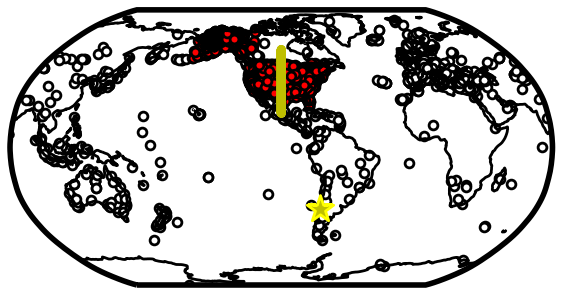

In [4]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
ax.set_global()
ax.coastlines()
plt.scatter(ISCarrLon, ISCarrLat, color='white', s=10, marker='o',transform=ccrs.PlateCarree(), edgecolors='black')
plt.scatter(USarrLon, USarrLat, color='red', s=10, marker='o',transform=ccrs.PlateCarree(), edgecolors='black')
plt.scatter(LON_EQ, LAT_EQ, color='y', s=100, marker='*',transform=ccrs.PlateCarree(), edgecolors='yellow',zorder=3)
# plt.scatter(result['LON'], result['LAT'], color='white', s=10, marker='v',transform=ccrs.PlateCarree(), edgecolors='none')
plt.scatter(LON_LINE, LAT_LINE, color='y', s=10, marker='o',transform=ccrs.PlateCarree(), edgecolors='none',zorder=4)
plt.savefig(figures_path+eq_name+'_sourei_map_'+plot_type+str(NO)+'.pdf', bbox_inches="tight")

16


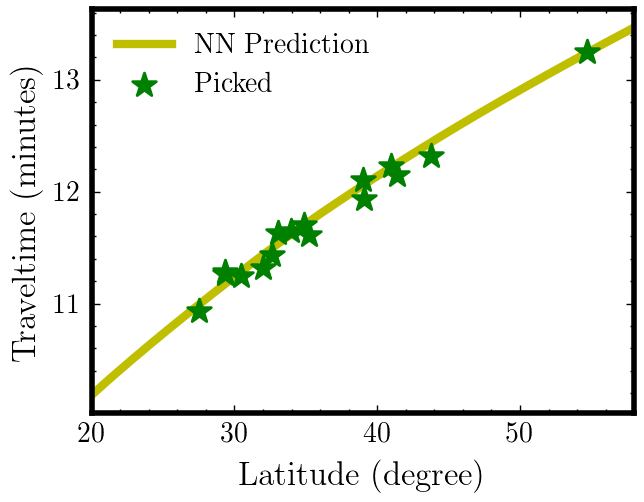

In [5]:
fig, ax = plt.subplots()
if plot_type=='lon_wise':
    ax.plot(LAT_LINE, T_LINE[:len(LON_LINE)], 'y', linewidth=3, label='NN Prediction')
    # ax.plot(LAT_LINE, T_EIK, '-.b', linewidth=3, label='1-D Velocity Calculated')
    # ax.plot(THE/np.pi*180-90,T_pyk[0,:,LINE_IDX-366]/60, '--k', linewidth=3, label='3-D Velocity Calculated')
    ax.scatter(result['LAT'], result['P-arrival in Minutes'], s=80, marker='*', c='g', label='Picked',zorder=4)
    ax.set_xlabel('Latitude (degree)')
    ax.set_xlim(LAT_1, LAT_2)
    # ax.set_ylim(11,14.5)
    print(len(result['P-arrival in Minutes'].values))
else:
    ax.scatter(result['LON'], result['P-arrival in Minutes'], s=80, marker='*', c='g', label='Picked',zorder=4)
    ax.plot(LON_LINE, T_LINE[:len(LAT_LINE)], 'y', linewidth=3, label='NN Prediction')
    # ax.plot(LON_LINE, T_EIK, '-.b', linewidth=3, label='1-D Velocity Calculated')
    # ax.plot(PHI/np.pi*180-180,T_pyk[0,LINE_IDX,:]/60, '--k', linewidth=3, label='3-D Velocity Calculated')
    ax.set_xlabel('Longitude (degree)')
    ax.set_xlim(LON_1, LON_2)
    print(len(result['P-arrival in Minutes'].values))
# ax = plot_travel_times(source_depth=10, ax=ax, fig=fig,phase_list=['P'], npoints=100, legend=True, show=False)
# plt.title('P-Phase Traveltime Curve Comparison')
ax.set_ylabel('Traveltime (minutes)')
# ax.set_xlim(-150,-50)
# ax.set_ylim(10,14)
plt.legend()
plt.savefig(figures_path+eq_name+'_TT_curve_'+plot_type+str(NO)+'.pdf', bbox_inches="tight")
plt.show()

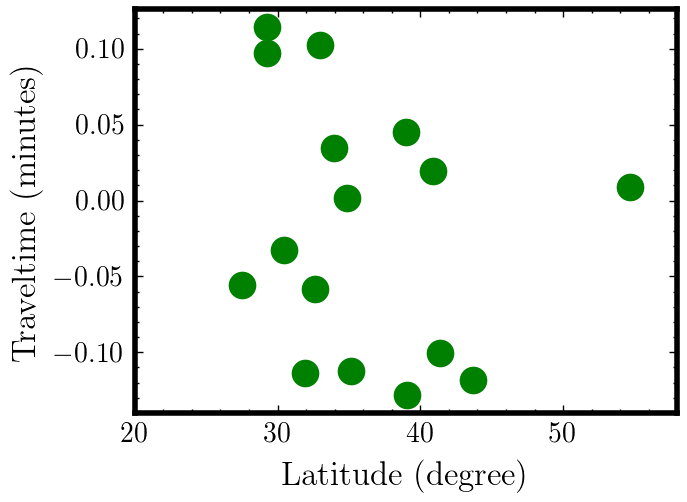

In [6]:
fig, ax = plt.subplots()
if plot_type=='lon_wise':
    # ax.plot(LAT_LINE, (T_LINE[:len(LON_LINE)]-T_EIK), c='k', label=r'T$_{\text{NN}}$ - T$_{\text{1-D}}$', linewidth=3)
    # ax.scatter(LAT_LINE[LAT_IDX_REC], (T_RES-T_EIK[LAT_IDX_REC]), s=80, marker='*', c='g', label=r'T$_{\text{OBS}}$ - T$_{\text{1-D}}$')
    ax.scatter(LAT_LINE[LAT_IDX_REC], (T_RES-T_LINE[LAT_IDX_REC]), s=80, marker='o', c='g', label=r'T$_{\text{OBS}}$ - T$_{\text{NN}}$')
    ax.set_xlabel('Latitude (degree)')
    ax.set_xlim(LAT_1, LAT_2)
else:
    # ax.plot(LON_LINE, (T_LINE[:len(LAT_LINE)]-T_EIK), c='k', label=r'T$_{\text{NN}}$ - T$_{\text{1-D}}$', linewidth=3)
    ax.scatter(LON_LINE[LON_IDX_REC], (T_RES-T_LINE[LON_IDX_REC]), s=80, marker='o', c='g', label=r'T$_{\text{OBS}}$ - T$_{\text{NN}}$')
    ax.set_xlim(LON_1, LON_2)
    ax.set_xlabel('Longitude (degree)')
# plt.title('P-Phase Traveltime Residual Curve Comparison')
ax.set_ylabel('Traveltime (minutes)')
# plt.legend()
plt.savefig(figures_path+eq_name+'_TT_res_'+plot_type+str(NO)+'.pdf', bbox_inches="tight")
plt.show()

In [7]:
figures_path

'./../saves/section-3/'

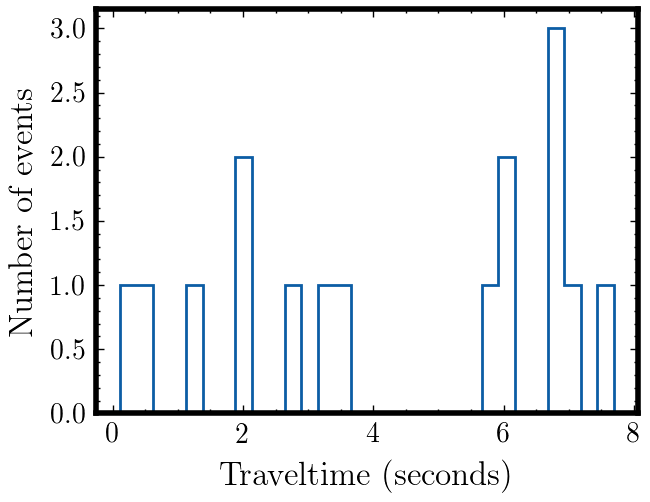

In [8]:
if plot_type=='lon_wise':
    hist_pinn = 60*(abs((T_RES-T_LINE[LAT_IDX_REC]))) #-np.mean(abs(T_RES-T_LINE[LAT_IDX_REC])))+3.1339114796032
    hist_1d = 60*(abs((T_RES-T_EIK[LAT_IDX_REC]))) #-np.mean(abs(T_RES-T_EIK[LAT_IDX_REC])))+2.95624943
else:
    hist_pinn = 60*(abs((T_RES-T_LINE[LON_IDX_REC]))) #-np.mean(abs(T_RES-T_LINE[LAT_IDX_REC])))+3.1339114796032
    hist_1d = 60*(abs((T_RES-T_EIK[LON_IDX_REC]))) #-np.mean(abs(T_RES-T_EIK[LAT_IDX_REC])))+2.95624943    

plt.figure()
plt.hist(hist_pinn, bins=30, stacked=1, label=['NN'], histtype='step')
# plt.hist(hist_1d, bins=30, stacked=1, label=['1-D'], histtype='step', range=(0, 3))
plt.xlabel('Traveltime (seconds)')
plt.ylabel('Number of events')
# plt.legend()
plt.savefig(figures_path+eq_name+'_hist_'+plot_type+str(NO)+'.pdf', bbox_inches="tight")
plt.show()